# CSV Files

In the last chapter, we found a directory called `data`. We know Boreas was using this data to choose his vacation location.

Each file contains hourly temperature data for a U.S. national park. Our mission: combine them into a single dataset so we can figure out which park is the coldest and then find Boreas!

We'll learn how to:

- Read .csv files with pandas
- Extract metadata (lat/lon/park name) from filenames
- Combine data into a single, gridded xarray.Dataset
- Save it as a NetCDF file for easy analysis

## Step 1: Explore the data directory

In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
files = os.listdir('data')
print(f'There are {len(files)} files')

There are 70 files


Woah! Look at all of those files! We have to process all of that?!

Maybe we can find a way to make it easier to process all of the data at once. Let's investigate of few of the filenames

In [3]:
for file in files[:5]:
    print(file)

Yellowstone-National-Park_249.411484_44.423691_.csv
Steller-Sea-Lion-Protection-Area_206.566666_57.466667_.csv
White-Sands-National-Park_253.828331_32.77972_.csv
Gates-of-the-Arctic-National-Park-and-Preserve_206.53627_67.915199_.csv
Everglades-National-Park_279.101349_25.286615_.csv


Hmmm. There seems to be a specific format for the file names. It appears to be something like (just guessing here, based off of the fact that I made the data) `ParkName_Longitude_Latitude_.csv`

Let's crack one open and take a look at what's inside. One of the best packages for processing data in python is [pandas](https://pandas.pydata.org/docs/index.html).

In [4]:
df = pd.read_csv('data/Yellowstone-National-Park_249.411484_44.423691_.csv')
print(df.shape)

(2920, 2)


In [5]:
df

,time,air
0,2013-01-01 00:00:00,260.10000
1,2013-01-01 06:00:00,259.40000
2,2013-01-01 12:00:00,260.00000
3,2013-01-01 18:00:00,259.19998
4,2013-01-02 00:00:00,263.00000
...,...,...
2915,2014-12-30 18:00:00,248.39000
2916,2014-12-31 00:00:00,251.68999
2917,2014-12-31 06:00:00,249.59000
2918,2014-12-31 12:00:00,254.68999


In [6]:
df.describe()

,air
count,2920.000000
mean,276.783465
std,11.559525
min,238.890000
25%,269.000000
50%,275.400000
75%,285.699980
max,303.199980


We know that Boreas is searching for the national park with the coldest temperature, and we’ve got 70 CSV files, one for each park, each with about 2,920 rows of hourly temperature data.

We could write a loop that goes through each file, reads in the data, tracks the minimum temperature in each park, and finds the lowest of them all. That would work fine for this small example. We’ve already shown how to calculate summary statistics from individual CSVs.

But what if we were working with a million locations around the globe, each with years of data? Reading one file at a time would quickly become slow, repetitive, and hard to scale.

This is where NetCDF comes in. NetCDF is a powerful format for working with large, structured datasets like gridded or time series environmental data.

By converting our CSVs into a single NetCDF file, we can organize the data along meaningful dimensions like location and time. Then we can use tools like [xarray](https://docs.xarray.dev/en/stable/) to compute operations, such as the minimum temperature across time at each park, all at once.

This kind of transformation makes it much easier to answer questions that involve comparing across datasets, especially as the data size grows.

Let's do that transformation now! First, how do we get the name, lat, and lon as it's own data variable? String operations!

In [7]:
file = files[0]

In [8]:
file

'Yellowstone-National-Park_249.411484_44.423691_.csv'

So we need to split that data into parts. [String splitting](https://docs.python.org/3/library/stdtypes.html#str.split) to the rescue.

In [9]:
file.split('_')

['Yellowstone-National-Park', '249.411484', '44.423691', '.csv']

Cool, `split`ing along an `_` gives us a list with the name in the first position, longitude in the second, and latitude in the third!

In [10]:
split = file.split('_')
name = split[0]
lon = split[1]
lat = split[2]

In [11]:
print(f'{name} is at ({lon}, {lat})')

Yellowstone-National-Park is at (249.411484, 44.423691)


Now we know how to get the metadata. Let's look at how we can create an xarray dataset. We'll make some toy datasets to illustrate how we can turn CSV tabular data into a gridded dataset, and then you can expand on the example to combine all 70 files. 

The key points are
- Add location information
- Stack multiple datasets together
- Make a grid. To make this tutorial easy, I will give you the grid you should use, but in practice you would have to define this yourself.
- Let pandas do some magic to create a gridded dataset

In [12]:
df1 = pd.DataFrame({
    "time": pd.date_range("2020-01-01", periods=3, freq="D"),
    "temperature": [10, 1, 33],
})
df1['park'] = "Yellowstone"
df1['lat'] = 44.6
df1['lon'] = -110.5

df2 = pd.DataFrame({
    "time": pd.date_range("2020-01-01", periods=3, freq="D"),
    "temperature": [30, 5, 25],
})
df2["park"] = "Grand Canyon"
df2["lat"] = 36.1
df2["lon"] = -112.1

df3 = pd.DataFrame({
    "time": pd.date_range("2020-01-01", periods=3, freq="D"),
    "temperature": [10, 20, 30],
})
df3["park"] = "Denali"
df3["lat"] = 63.1
df3["lon"] = -151.0

display(df1)
display(df2)
display(df3)

,time,temperature,park,lat,lon
0,2020-01-01,10,Yellowstone,44.6,-110.5
1,2020-01-02,1,Yellowstone,44.6,-110.5
2,2020-01-03,33,Yellowstone,44.6,-110.5


,time,temperature,park,lat,lon
0,2020-01-01,30,Grand Canyon,36.1,-112.1
1,2020-01-02,5,Grand Canyon,36.1,-112.1
2,2020-01-03,25,Grand Canyon,36.1,-112.1


,time,temperature,park,lat,lon
0,2020-01-01,10,Denali,63.1,-151.0
1,2020-01-02,20,Denali,63.1,-151.0
2,2020-01-03,30,Denali,63.1,-151.0


Now we want to combine these datasets, first we need to stack them, one on top of the other.

In [13]:
df_all = pd.concat([df1, df2, df3], ignore_index=True)

Now let's setup a grid. In practice you would need to figure out what grid you need for your data, but for this toy example and for the actual assignment of this notebook, we will provide you the grid.

In [14]:
lats = np.arange(30, 75, 5)
lons = np.arange(-160, -95, 5)
times = pd.date_range("2020-01-01", periods=3)

Next, we need to create an xarray dataset that we can assign data to. We will grid it on latitude, longitude, and time. The temperature variable will be on the lat/lon/time grid, will the park name will only be on the lat/lon grid. We will use a `NaN` value (not a number) for the default grid value.

In [15]:
ds = xr.Dataset(
    {
        "temperature": (("lat", "lon", "time"), np.full((len(lats), len(lons), len(times)), np.nan)),
        "park_name": (("lat", "lon"), np.full((len(lats), len(lons)), "", dtype=object)),
    },
    coords={"lat": lats, "lon": lons, "time": times},
)

Next we need to iterate over the stacked dataframe in groups using [pandas groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html). We will select the grid value that most closely matches the location of the file, and then assign the temperature and park name accordingly

In [16]:
for (park, lat, lon), group in df_all.groupby(["park", "lat", "lon"]):
    # Select nearest grid cell
    sel = ds.sel(lat=lat, lon=lon, method="nearest")
    lat_sel = sel.lat.values.item()
    lon_sel = sel.lon.values.item()
    
    temps = group["temperature"].values
    ds["temperature"].loc[dict(lat=lat_sel, lon=lon_sel)] = temps
    
    # Assign park name for that cell
    ds["park_name"].loc[dict(lat=lat_sel, lon=lon_sel)] = park

After all of that work, we have one dataset with temperature values and names.

In [17]:
ds

<xarray.Dataset>
Dimensions:      (lat: 9, lon: 13, time: 3)
Coordinates:
  * lat          (lat) int64 30 35 40 45 50 55 60 65 70
  * lon          (lon) int64 -160 -155 -150 -145 -140 ... -115 -110 -105 -100
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 2020-01-03
Data variables:
    temperature  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    park_name    (lat, lon) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''

To verify, let's make a quick plot. We will show you how to make fancier plots in the next notebook, but for now this is good enough to see that your data got in.

In [18]:
vmin, vmax = ds.temperature.min(), ds.temperature.max()

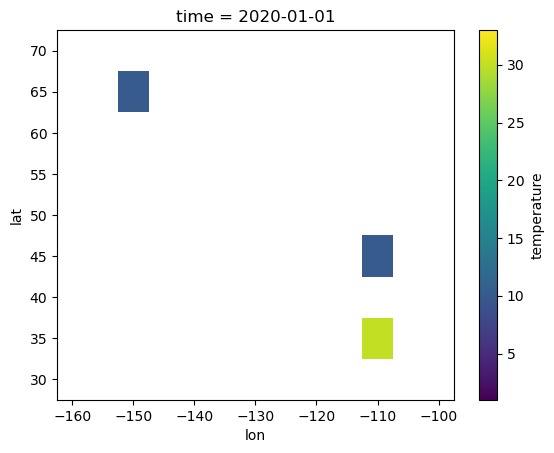

In [19]:
ds.isel(time=0)['temperature'].plot(vmin=vmin, vmax=vmax)

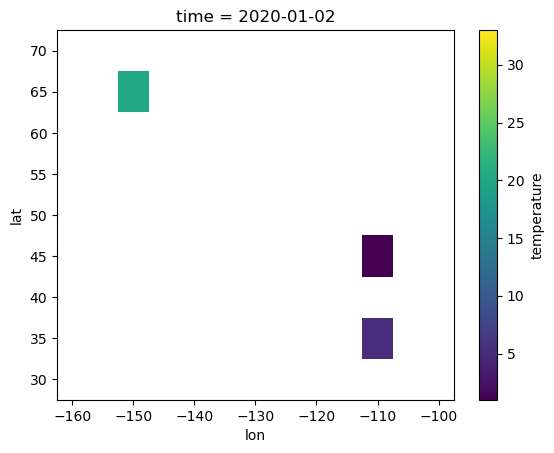

In [20]:
ds.isel(time=1)['temperature'].plot(vmin=vmin, vmax=vmax)

Then, to save the dataset off to a netcdf file, simply tell xarray to do that for you!

In [21]:
ds.to_netcdf("example.nc")

## Now You Try: Process the Full Dataset

Now you know enough to make your own netcdf dataset using all of the data files you have! We've left some shell code below and predefined variables for you to use to do this work. Please don't spend too long on this, if yout get stuck, we have premade solutions as well as datasets that you can use for the next notebook.

In [22]:
longitudes = np.arange(200, 331, 2.5)
latitudes = np.arange(75, 14, -2.5)
times = pd.date_range(start="2013-01-01", end="2014-12-31 18:00:00", freq="6H")

In [23]:
all_dfs = []
for file in files:
    df = pd.read_csv(f'data/{file}')
    split = file.split('_')
    df['park'] = split[0]
    df['lon'] = split[1]
    df['lat'] = split[2]
    all_dfs.append(df)

In [24]:
ds = xr.Dataset(
    {
        "temperature": (("lat", "lon", "time"), np.full((len(latitudes), len(longitudes), len(times)), np.nan)),
        "park_name": (("lat", "lon"), np.full((len(latitudes), len(longitudes)), "", dtype=object)),
    },
    coords={"lat": latitudes, "lon": longitudes, "time": times},
)

In [25]:
df_all = pd.concat(all_dfs, ignore_index=True)

In [26]:
for (park, lat, lon), group in df_all.groupby(["park", "lat", "lon"]):
    # Select nearest grid cell
    sel = ds.sel(lat=lat, lon=lon, method="nearest")
    lat_sel = sel.lat.values.item()
    lon_sel = sel.lon.values.item()
    
    temps = group["air"].values
    ds["temperature"].loc[dict(lat=lat_sel, lon=lon_sel)] = temps
    
    # Assign park name for that cell
    ds["park_name"].loc[dict(lat=lat_sel, lon=lon_sel)] = park

In [27]:
ds

<xarray.Dataset>
Dimensions:      (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat          (lat) float64 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon          (lon) float64 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time         (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    temperature  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan
    park_name    (lat, lon) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''

In [28]:
ds.to_netcdf("national_park_temperatures.nc")

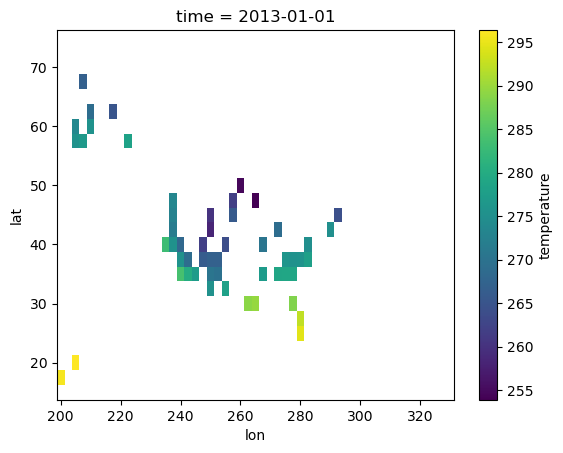

In [29]:
ds.isel(time=0)['temperature'].plot()